### QED-C Application-Oriented Benchmarks - Hamiltonian Simulation with HamLib - Evolution

The notebook contains specific examples for the HamLib-based Hamiltonian Simulation benchmark program.
Configure and run the cell below with the desired execution settings.
Then configure and run the remaining cell(s), each one a variation of this benchmark.

This example illustrates the evolution of the specified Hamiltonian over time "t", uwing "K" Trotter steps. The energy and several other observables is computed using an exact classical algorithm and the quantum algorithm at each step and the results recorded for plotting.  The time of execution is also recorded.

Currently this example operates on only one fixed size for each type of Hamiltonian and produces plots representing the evolution of the various observables.

### Program Configuration

In [1]:
import sys, time
import numpy as np

# Select the API to use and load the benchmark program
api = "qiskit"
from hamlib_simulation_benchmark import find_pauli_groups

sys.path.insert(1, "_common")
sys.path.insert(1, "qiskit")

# Import HamLib, observable, and evolution helper functions (from _common)
from hamlib_utils import load_hamlib_file, get_hamlib_sparsepaulilist
from observables import calculate_expectation_from_measurements, ensure_pauli_terms
from evolution_exact import compute_expectations_exact

# Import Hamlib Simulation kernel (from qiskit)
import hamlib_simulation_kernel

############## Settings

# Select the benchmark parameters
num_qubits = min_qubits = max_qubits = 4
skip_qubits=1
max_circuits=1
num_shots=10000

# Total evolution time and size of each Trotter step
total_evolution_time = 6.3
step_size = 0.25

# Select the backend 
#backend_id="qasm_simulator"
backend_id="statevector_simulator"
provider_backend=None
exec_options={}

verbose = True

###############

# place resulting data and images into a folder with "paper" suffix
# import metrics
# metrics.data_suffix = "_evolution"
# hamlib_simulation_benchmark.data_suffix = "_evolution"

# Set numpy print options to format floating point numbers
#np.set_printoptions(precision=3, suppress=True)


### List of Available Hamiltonians and Sizes
For the example illustrated below, select one of the available Hamiltonian (name, params, size) tuples.


In [2]:
# list of observable computation methods to sweep
group_method_list = [ None, "simple", "N", "estimator" ]

# List of HamLib filename and parameter tuples, with max_qubits limit array
# Note that the 4th entry in the array is used in the cell below which executes a noisy simulation
hamiltonians = [
    ('condensedmatter/tfim/tfim', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/heisenberg/heis', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/fermihubbard/FH_D-1', { "1D-grid": "pbc", "enc": "bk", "U":12 }, [20,24,24,24, 14] ),
    ('condensedmatter/bosehubbard/BH_D-1_d-4', { "1D-grid": "nonpbc", "enc": "gray", "U":10 }, [16,24,24,24, 12] ),
    ('binaryoptimization/max3sat/random/random_max3sat-hams', { "ratio": "2", "rinst": "02" }, [18,28,28,28, 14] ),
    ('chemistry/electronic/standard/H2', { "ham_BK": "" }, [8,12,12,12, 8] )
    ]

# Select indices of the Hamiltonian(s) to test
ham_indexes = range(len(hamiltonians))       # select all
#ham_indexes = [2,3]       # select subset, for example 2,3; for quick test, do just one of them

# limit testing to simple for now
group_method = "simple"

# just do one Hamiltonian for now
ham_indexes = [ 0 ]

# get Hamiltonian name and params from list
# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[0]

print(f"\n*******************************************************************************************")

print(f"Hamiltonian Energy/Observables Evolution for {hamiltonian_name} {hamiltonian_params}\n")

print("============================================================")
print(f"Testing expectation grouping method: {group_method}\n") 



*******************************************************************************************
Hamiltonian Energy/Observables Evolution for condensedmatter/tfim/tfim {'1D-grid': 'pbc', 'h': 2}

Testing expectation grouping method: simple



### Load the Selected Hamiltonian and get Pauli Terms
Use the selected Hamiltonian name and parameters to obtain the Pauli terms for a specific dataset.

In [3]:
# load the HamLib file for the given hamiltonian name
load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)
print(f"... dataset_name = {dataset_name}")
print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")

print("")

... dataset_name = graph-1D-grid-pbc-qubitnodes_Lx-4_h-2
... sparse_pauli_terms = 
[({0: 'Z', 1: 'Z'}, (1+0j)), ({0: 'Z', 3: 'Z'}, (1+0j)), ({1: 'Z', 2: 'Z'}, (1+0j)), ({3: 'Z', 2: 'Z'}, (1+0j)), ({0: 'X'}, (2+0j)), ({1: 'X'}, (2+0j)), ({3: 'X'}, (2+0j)), ({2: 'X'}, (2+0j))]



### Arrange Pauli Terms into Commuting Groups

In [4]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below
pauli_term_groups, pauli_str_list = find_pauli_groups(num_qubits, sparse_pauli_terms, group_method)

print(f"... Number of groups created: {len(pauli_term_groups)}")
print(f"... Pauli Term Groups:")
for group in pauli_term_groups:
    print(group)
        


... finished grouping terms, total grouping time = 0.0 sec.

... Number of groups created: 2
... Pauli Term Groups:
[('ZZII', (1+0j)), ('ZIIZ', (1+0j)), ('IZZI', (1+0j)), ('IIZZ', (1+0j))]
[('XIII', (2+0j)), ('IXII', (2+0j)), ('IIIX', (2+0j)), ('IIXI', (2+0j))]


### Create Measurement Circuits from Base Circuit and Pauli Terms
Here, we append basis rotation gates for each Pauli Term group to the base evolution circuit to create an array of circuits for execution.

In [5]:
# generate an array of circuits, one for each pauli_string in list
def create_measurement_circuts(qc, num_qubits, pauli_term_groups, pauli_str_list):
    ts = time.time()
    
    circuits = hamlib_simulation_kernel.create_circuits_for_pauli_terms(qc, num_qubits, pauli_str_list)
    """
    print(f"... Appended {len(circuits)} circuits, one for each group:")               
    for circuit, group in list(zip(circuits, pauli_term_groups)):
        print(group)
        #print(circuit)
    """
    append_time = round(time.time()-ts, 3)
    ###print(f"\n... finished appending {len(circuits)} measurement circuits, total creating time = {append_time} sec.\n")

    return circuits


In [6]:
def do_execute(circuits, num_shots):
    
    # Initialize simulator backend
    from qiskit_aer import Aer
    backend = Aer.get_backend('qasm_simulator')
    #backend = Aer.get_backend('statevector_simulator')     # doesn't work, only returns 1 shot
    
    ### print(f"... begin executing {len(circuits)} circuits ...")
    ts = time.time()
    
    # Execute all of the circuits to obtain array of result objects
    results = backend.run(circuits, num_shots=num_shots).result()

    #for ca in results.get_counts():
    #    print(ca)
    
    exec_time = round(time.time()-ts, 3)
    ###print(f"... finished executing {len(circuits)} circuits, total execution time = {exec_time} sec.\n")

    return results


In [7]:
# Compute the total energy for the Hamiltonian
def compute_energy(num_qubits, results, pauli_term_groups):

    ###print(f"... begin computing observable value ...")
    ts = time.time()
    
    total_energy, term_contributions = calculate_expectation_from_measurements(
                                                num_qubits, results, pauli_term_groups)
    obs_time = round(time.time()-ts, 3)
    ###print(f"... finished computing observable value, computation time = {obs_time} sec.\n")
    
    #print(f"    Total Energy: {round(np.real(total_energy), 4)}")
    ### print(f"    Term Contributions: {term_contributions}\n")

    create_time = 0
    group_time = 0
    append_time = 0
    exec_time = 0
    
    total_time = group_time + create_time + append_time + exec_time + obs_time
    total_time = round(total_time, 3)
    ###print(f"\n... total observable computation time = {total_time} sec.\n")
    
    return total_energy


### Quantum Evolution - Calculate Exact Theoretical Energy and Time Arrays for Multiple Steps
Here, we create an array containing a series of time values for increasing longer evolution times along with the computed theoretical energy at each time step, given the initial state. 
Note that the energy remains constant since these are a time-independent Hamiltonians.

In [8]:
print("========= Exact Classical Calculation of Energy and Time Arrays\n")

# Define an array of time values from 0 to the total evolution time
time_values = np.arange(0, total_evolution_time + step_size, step_size)

########### Obtain exact energies and time values for successively longer evolution times

print(f"... getting exact energies")

ts = time.time()

theoretical_energies = 0
magnetization_energies = 0
correlation_energies = 0

init_state = "checkerboard"

if verbose:
    print(f"... begin exact computation for id={type} ...")

ts = time.time()

################ Using newer evolution_exact code:

theoretical_energies = compute_expectations_exact(
        init_state,
        ensure_pauli_terms(sparse_pauli_terms, num_qubits),
        total_evolution_time,
        step_size
        )                 
        
exact_time = round((time.time() - ts), 3)

#if verbose:
print(f"... exact computation time = {exact_time} sec")

# Create array of theoretical energies (for comparison)
# We compute this in an array function so that we can do the matrix conversion just once for all the steps
#theoretical_energies = evolution_exact.compute_expectations_exact(initial_state, H.to_list(), total_evolution_time, step_size)
# magnetization_energies = evolution_exact.compute_expectations_exact(initial_state, magnetization_op.to_list(), total_evolution_time, step_size)
# correlation_energies = evolution_exact.compute_expectations_exact(initial_state, correlation_op.to_list(), total_evolution_time, step_size)

print(f"... total compute_expectations_exact time = {round(time.time()-ts, 3)}")

print(f"\n... got exact energies {theoretical_energies}")
# print(f"\n... got magnetization = {magnetization_energies}")
# print(f"\n... got correlation = {correlation_energies}")


========= Exact Classical Calculation of Energy and Time Arrays

... getting exact energies
... begin exact computation for id=<class 'type'> ...
... exact computation time = 0.023 sec
... total compute_expectations_exact time = 0.023

... got exact energies [-4.0, -3.9999999999999996, -4.0, -4.000000000000001, -4.0, -4.000000000000001, -4.0000000000000036, -3.999999999999995, -3.999999999999995, -3.9999999999999867, -3.9999999999999822, -3.9999999999999636, -3.999999999999969, -3.9999999999999027, -3.999999999999903, -3.9999999999999027, -3.9999999999999023, -3.9999999999999027, -3.999999999999903, -3.9999999999999014, -3.999999999999901, -3.9999999999999023, -3.999999999999903, -3.999999999999892, -3.9999999999998774, -3.9999999999998566, -3.9999999999998277]


In [9]:


# create Trotterized evolution circuit for HamLib Hamiltonian
def create_base_circuit(num_qubits, init_state, sparse_pauli_terms, K = 0, t = 0):
    ts = time.time()
    qc, _ = hamlib_simulation_kernel.HamiltonianSimulation(
        num_qubits=num_qubits, 
        ham_op=sparse_pauli_terms,
        K=K, t=t,
        init_state = init_state,
        append_measurements = False,
        method = 1, 
    )
    
    create_time = round(time.time()-ts, 3)
    print(f"\n... finished creating base circuit, total creation time = {create_time} sec.\n")
    
    print(f"... Trotterized Circuit, K={K}, t={t}")
    """
    if num_qubits < 11:
        if hamiltonian_name != '':
            hamlib_simulation_kernel.kernel_draw(qc, method=1)
        else:
            print(qc)
    else:
        print("  ... circuit is too large to draw.")
    
    print("")
    """
    return qc


### Perform Test 2 - Quantum Evolution - Compute Multiple Observables for Multiple Steps
Here, we populate arrays of energy and other observables at increasing time steps using quantum circuit evolution and measurement.

In [10]:
print("========= Quantum Simulation of Evolution and Calculation of Observables\n")
# print(H)
# print(H_terms)
# print(initial_state)

########### Obtain multiple observables for successively longer evolution times

use_commuting_groups = True

observables_list = []

ts = time.time()

# Define a time array
time_values = np.arange(0, total_evolution_time + step_size, step_size)


# loop over successively longer time steps to create arrays of obeservable values
# by creating an increasingly long quantum circuit and computing observables from execution results
for step in range(len(time_values)):
    print(".", end="")
    """
    # create a quantum circuit for this step, from the first of the Hamiltonians in the first element of the array
    qc = kernel.create_quantum_test_circuit(initial_state, H_terms_multiple[0], step, step_size)
    
    # Estimate expectation for the Ham terms using the circuit qc
    total_energy, term_contributions = obs.estimate_expectation_value(backend, qc, obs.swap_pauli_list(H_terms_multiple[0]), 
                                             use_commuting_groups=use_commuting_groups, num_shots=10000)
    """
    
    qc = create_base_circuit(num_qubits, init_state, sparse_pauli_terms, K = step, t = time_values[step])



    #print(qc)

    # Append measurement circuits for each term group and return an array of circuits
    circuits = create_measurement_circuts(qc, num_qubits, pauli_term_groups, pauli_str_list)

    #for c in circuits:
    #    print(c)

    results = do_execute(circuits, num_shots)

    energy = compute_energy(num_qubits, results, pauli_term_groups)
    energy = np.real(energy)

    total_energy = energy
    
    #H_terms_spin_correlation = obs.swap_pauli_list(H_terms_multiple[1])
    #spin_correlation = obs.calculate_expectation_from_contributions(term_contributions, H_terms_spin_correlation)
    spin_correlation = 0
    
    #H_terms_magnetization = obs.swap_pauli_list(H_terms_multiple[2])
    #magnetization = obs.calculate_expectation_from_contributions(term_contributions, H_terms_magnetization)
    magnetization = 0
    
    obs = [ total_energy, spin_correlation, magnetization ]
    
    # append these observables to a list for plotting
    observables_list.append(obs)
    
print("")

print(f"... cumulative elapsed execution time = {round(time.time()-ts, 3)}")


========= Quantum Simulation of Evolution and Calculation of Observables

.
... finished creating base circuit, total creation time = 0.011 sec.

... Trotterized Circuit, K=0, t=0.0
.
... finished creating base circuit, total creation time = 0.005 sec.

... Trotterized Circuit, K=1, t=0.25
.
... finished creating base circuit, total creation time = 0.005 sec.

... Trotterized Circuit, K=2, t=0.5
.
... finished creating base circuit, total creation time = 0.007 sec.

... Trotterized Circuit, K=3, t=0.75
.
... finished creating base circuit, total creation time = 0.009 sec.

... Trotterized Circuit, K=4, t=1.0
.
... finished creating base circuit, total creation time = 0.01 sec.

... Trotterized Circuit, K=5, t=1.25
.
... finished creating base circuit, total creation time = 0.018 sec.

... Trotterized Circuit, K=6, t=1.5
.
... finished creating base circuit, total creation time = 0.013 sec.

... Trotterized Circuit, K=7, t=1.75
.
... finished creating base circuit, total creation time =

In [11]:
print(observables_list)

[[-4.01953125, 0, 0], [-1.1328125, 0, 0], [-4.11328125, 0, 0], [-3.453125, 0, 0], [-3.08203125, 0, 0], [-3.27734375, 0, 0], [-2.625, 0, 0], [-2.4140625, 0, 0], [-4.48828125, 0, 0], [-3.22265625, 0, 0], [-1.21484375, 0, 0], [-4.375, 0, 0], [-3.07421875, 0, 0], [-3.0625, 0, 0], [-3.5, 0, 0], [-2.0078125, 0, 0], [-2.8515625, 0, 0], [-4.30859375, 0, 0], [-3.2890625, 0, 0], [-1.59765625, 0, 0], [-4.54296875, 0, 0], [-2.5859375, 0, 0], [-3.43359375, 0, 0], [-3.62109375, 0, 0], [-1.60546875, 0, 0], [-4.1171875, 0, 0], [-4.07421875, 0, 0]]


In [12]:

H_terms = sparse_pauli_terms
H_terms_spin_correlation = []
H_terms_magnetization = []

H_terms_multiple = [H_terms, H_terms_spin_correlation, H_terms_magnetization] #pass this into a function, and check if each term is in.
H_terms_names = ["Energy", "Spin Correlation", "Magnetization"]

### Plot Results
Generate a plot showing the expectation value of multiple observables over successively longer Trotterized evolution times

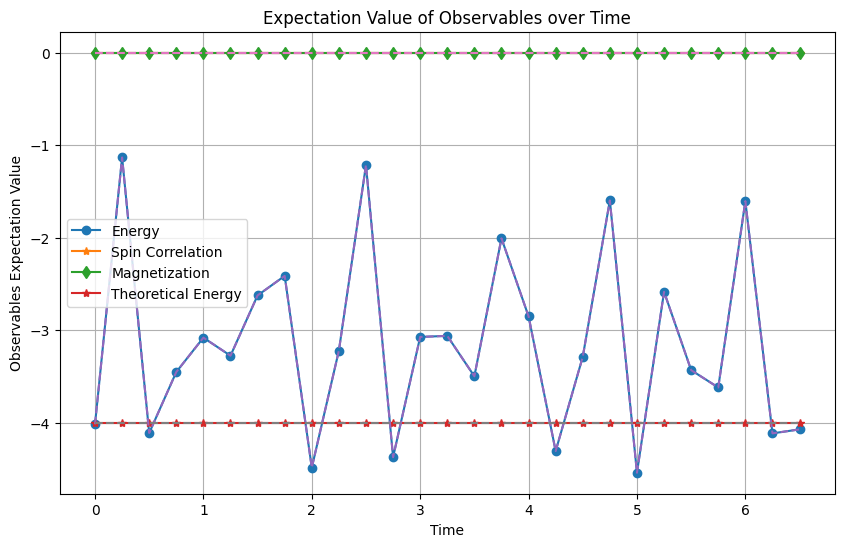

In [13]:
import matplotlib.pyplot as plt

########### Transform Data for Plotting

observables_values_list = []

# pre-populate the observables value arrays with empty arrays
for i in range(len(H_terms_multiple)):
    observables_values_list.append([])

# for each step, put the values of the computed observables into the values array, for plotting
for step in range(len(time_values)):
    for j in range(len(observables_list[step])):
        observables_values_list[j].append(observables_list[step][j])

########### Plot Results

# Plot the results
plt.figure(figsize=(10, 6))

marker=['o', '*', 'd', '1', '2']

#####
for i in range(len(H_terms_multiple)):
    plt.plot(time_values, observables_values_list[i], label= H_terms_names[i], marker=marker[i])

plt.plot(time_values, theoretical_energies, label='Theoretical Energy', marker='*')
# plt.plot(time_values, correlation_energies, label='Theoretical Correlation', marker='*')
# plt.plot(time_values, magnetization_energies, label='Theoretical Magnetization', marker='*')

#####
for j in range(len(H_terms_multiple)):
    plt.plot(time_values, observables_values_list[j], linestyle='--')
    
plt.plot(time_values, theoretical_energies, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Observables Expectation Value')
plt.title('Expectation Value of Observables over Time')
plt.legend()
plt.grid(True)
plt.show()
